# Support Vector Machines

Les SVMs sont très utilisés pour les classifications binaires. Nous allons voir s'ils fonctionnent bien pour le cas présent.
A chaque fois, j'équilibrerai le dataset (cela est important pour les SVM car la frontière peut facilement faire une séparation au milieu d'un ensemble si jamais les labels sont mal équilibrés) et je normaliserais les données (sinon ce n'est pas possible pour un SVM d'avoir de bons résultats avec des données trop éparses). 

Utiliser un PCA avant SVM peut changer complètement les résultats puisque cela change d'espace. Il n'est pas évident de dire que le PCA améliorera la prédiction cette fois-ci, je vais donc tester les deux méthodes, sur des noyaux linéaires et non linéaires. A chaque fois cependant j'utiliserai la cross validation pour avoir le meilleur paramètre de régularisation possible

In [1]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from collections import Counter
import imblearn
%matplotlib inline

import warnings
#from warnings import DataConversionWarning
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [2]:
df = pd.read_csv('data/train.csv')
X_df = df['ImageId']
y_df = df['Malignant']
names = X_df.values
y = y_df.values

df2 = pd.read_csv('data/features.csv')
features_df = df2.loc[df2['ImageId'].isin(names)]
features = np.array(features_df.values)
X = features[:,1:]
N,M=X.shape
class_names = ["healthy","melanoma"]

In [3]:
# Shuffle data randomly
indeces = np.arange(N)
np.random.shuffle(indeces)
X = X[indeces]
y = y[indeces]

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  


#Equilibrer le dataset

from imblearn.over_sampling import SMOTE, ADASYN
X_train, y_train = ADASYN().fit_resample(X_train, y_train)


## Linear SVM

### Without PCA

Best Score: 0.5153547289620621
Best params: {'C': 0.01}
Normalized confusion matrix
[[0.46590909 0.53409091]
 [0.40384615 0.59615385]]


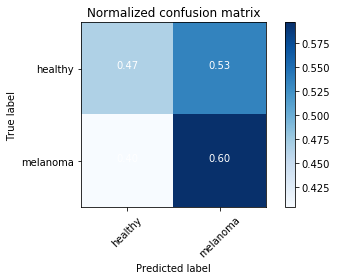

In [4]:
#score de Matthews
scorer = make_scorer(matthews_corrcoef)

# Fitting Linear SVM on original data

p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC(class_weight='balanced')
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
# Nested CV with parameter optimization


clf = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, cv=inner_cv)
nested_score = cross_val_score(clf, X_train, y_train, cv=outer_cv,scoring=scorer)

# Looking for the best hyperparameters
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="balanced_accuracy", cv=5)
grid_lsvm.fit(X_train, y_train)
print("Best Score: {}".format(grid_lsvm.best_score_))
print("Best params: {}".format(grid_lsvm.best_params_))

y_pred = grid_lsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

### Linear SVM with PCA

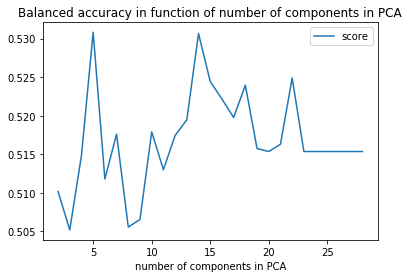

best score for 5 components
best score : 0.5308215839942582


In [5]:
l = []

for i in range(2,29) : 
    # Test at least one reduction technique with a linear and non-linear SVM
    pca = decomposition.PCA(n_components=i) # use number of components take explain 90% of variability
    pca.fit(X_train)
    X_pca = pca.transform(X_train)
    Xtest_pca = pca.transform(X_test)
    
    # Fitting SVM
    Lsvm = LinearSVC(class_weight='balanced')
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Nested CV with parameter optimization


    clf = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, cv=inner_cv)
    nested_score = cross_val_score(clf, X_train, y_train, cv=outer_cv,scoring="balanced_accuracy")
    # Looking for the best hyperparameters
    grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="balanced_accuracy", cv=5)
    grid_lsvm.fit(X_pca, y_train)

    
    l.append(grid_lsvm.best_score_)


    y_pred = grid_lsvm.predict(Xtest_pca)
    
plt.plot(range(2,29),l,label='score')
plt.title("Balanced accuracy in function of number of components in PCA")
plt.legend()
plt.xlabel('number of components in PCA')
plt.show()

print('best score for '+ str(np.argmax(l)+2)+ ' components')
print('best score : '+ str(max(l)))

Best Score: 0.5415438843103425
Best params: {'C': 8}
Normalized confusion matrix
[[0.53409091 0.46590909]
 [0.46153846 0.53846154]]


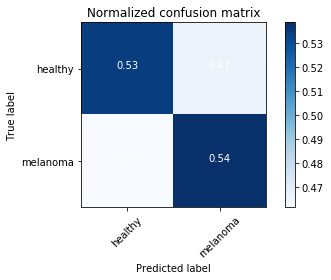

In [6]:
#PCA
pca = decomposition.PCA(n_components=5) # use number of components that has the best result
pca.fit(X_train)
X_pca = pca.transform(X_train)
Xtest_pca = pca.transform(X_test)



# Fitting Linear SVM on original data

p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC(class_weight='balanced')
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
# Nested CV with parameter optimization


clf = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, cv=inner_cv)
nested_score = cross_val_score(clf, X_pca, y_train, cv=outer_cv,scoring=scorer)

# Looking for the best hyperparameters
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="balanced_accuracy", cv=5)
grid_lsvm.fit(X_pca, y_train)
print("Best Score: {}".format(grid_lsvm.best_score_))
print("Best params: {}".format(grid_lsvm.best_params_))

y_pred = grid_lsvm.predict(Xtest_pca)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

L'utilisation de PCA améliore légèrement la prédiction pour le SVM à noyau linéaire mais cela est assez léger. Une autre méthode de sélection de features seraient peut -être judicieuse (comme par exemple la forward variable selection). 

Lors de la soumission des résultats cela a donné à chaque fois des scores négatifs même en ayant bien choisit le bon paramètre pour le PCA.
Vu les résultats, la séparation des features est non linéaire. J'essaie donc une résolution avec un SVM non linéaire. Les deux meilleurs noyaux sont les noyaux sigmoid et Rbf avec mon ensemble. 

# Non linear SVM

### RBF kernel

Best Score: 0.5473611195995743
Best params: {'C': 10.0, 'gamma': 0.1}
Normalized confusion matrix
[[0.51136364 0.48863636]
 [0.46153846 0.53846154]]


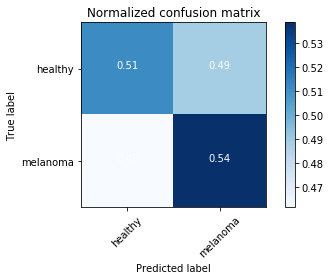

In [7]:
# Fitting Non-linear SVM

p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf', class_weight='balanced')
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)


outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
# Nested CV with parameter optimization
clf = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, cv=inner_cv)


# Looking for the best hyperparameters
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="balanced_accuracy", cv=5)
grid_nlsvm.fit(X_train, y_train)
print("Best Score: {}".format(grid_nlsvm.best_score_))
print("Best params: {}".format(grid_nlsvm.best_params_))


y_pred = grid_nlsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

### Sigmoid kernel

Best Score: 0.5269445371645817
Best params: {'C': 5, 'gamma': 0.005}
Normalized confusion matrix
[[0.375      0.625     ]
 [0.32692308 0.67307692]]


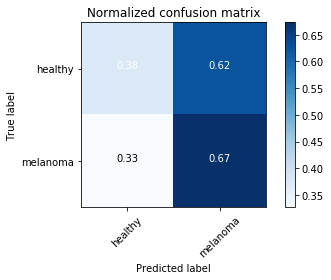

In [8]:
# Fitting Non-linear SVM

p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='sigmoid', class_weight='balanced')
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)


outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
# Nested CV with parameter optimization
clf = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, cv=inner_cv)
# Looking for the best hyperparameters
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="balanced_accuracy", cv=5)
grid_nlsvm.fit(X_train, y_train)
print("Best Score: {}".format(grid_nlsvm.best_score_))
print("Best params: {}".format(grid_nlsvm.best_params_))


y_pred = grid_nlsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

itération n°2
itération n°3
itération n°4
itération n°5
itération n°6
itération n°7
itération n°8
itération n°9
itération n°10
itération n°11
itération n°12
itération n°13
itération n°14
itération n°15
itération n°16
itération n°17
itération n°18
itération n°19
itération n°20
itération n°21
itération n°22
itération n°23
itération n°24
itération n°25
itération n°26
itération n°27
itération n°28


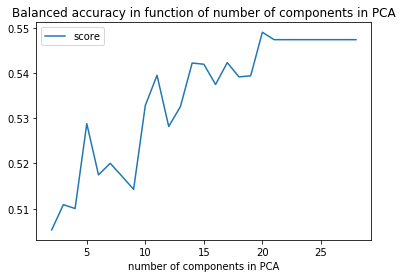

best score for 20 components
best score : 0.5490030495783714


In [9]:
l = []
for i in range(2,29) :     
    print('itération n°' + str(i))
    pca = decomposition.PCA(n_components=i) 
    pca.fit(X_train)
    X_pca = pca.transform(X_train)

    # Fitting Non-linear SVM
    p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    NLsvm = SVC(kernel='rbf', class_weight='balanced')
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, cv=inner_cv)
    nested_score = cross_val_score(clf, X_pca, y_train, cv=outer_cv)

    # Looking for the best hyperparameters
    grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="balanced_accuracy", cv=5)
    grid_nlsvm.fit(X_pca, y_train)
    l.append(grid_nlsvm.best_score_)
    

plt.plot(range(2,29),l,label='score')
plt.title("Balanced accuracy in function of number of components in PCA")
plt.legend()
plt.xlabel('number of components in PCA')
plt.show()

print('best score for '+ str(np.argmax(l)+2)+ ' components')
print('best score : '+ str(max(l)))

Best Score: 0.5422967195876645
Best params: {'C': 10.0, 'gamma': 0.1}
Normalized confusion matrix
[[0.51136364 0.48863636]
 [0.44230769 0.55769231]]


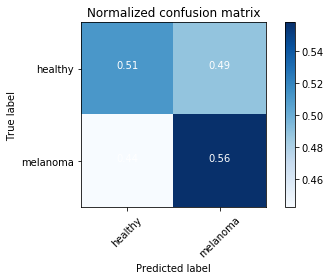

In [10]:
pca = decomposition.PCA(n_components=17) 
pca.fit(X_train)
X_pca = pca.transform(X_train)
Xtest_pca = pca.transform(X_test)


    # Fitting Non-linear SVM
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf', class_weight='balanced')
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    # Nested CV with parameter optimization
clf = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, cv=inner_cv)
nested_score = cross_val_score(clf, X_pca, y_train, cv=outer_cv)

    # Looking for the best hyperparameters
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="balanced_accuracy", cv=5)
grid_nlsvm.fit(X_pca, y_train)

print("Best Score: {}".format(grid_nlsvm.best_score_))
print("Best params: {}".format(grid_nlsvm.best_params_))


y_pred = grid_nlsvm.predict(Xtest_pca)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Sans surprise, les résultats de SVM avec un noyau non linéaire sont meilleurs. C'est le noyau rbf qui donne les meilleurs résultats. Cependant, les prédictions que j'ai pu soumettre à Kaggle ne sont pas aussi bonnes que celles que j'avais pu fournir avec les Randm Forest. 

Je n'ai pas pu soumettre la prédiction ci-dessus mais elle n'aurait pas eu un bon résultat puisque les nombres de faux positifs et de faux négatifs sont trop élevés. 

# Conclusion : 

Les support vector machines ne marchent vraiment pas très bien pour cette classification. Le noyau RBF est bien meilleur que le noyau sigmoid mais les deux ne sont pas très bons.
L'un des plus gros désavantages des SVM est que le choix des noyaux est très limité. Le problème, au vues des résultats des SVM linéaires, n'est pas linéaire. Il reste deux noyaux qui donnent des performances supérieures à 0.5 : le noyau sigmoid et le noyau rbf. Ces deux noyaux ne conviennent pas aux features et donc limitent grandement la résolution du problème. 
  Il se peut également que les features ne soit pas bonnes.

# Appendice : code implémenté pour soumettre les CSV.

In [11]:
#loading data
#train set :
df = pd.read_csv('data/train.csv')
X_df = df['ImageId']
y_df = df['Malignant']
names = X_df.values
y_train = y_df.values

df2 = pd.read_csv('data/features.csv')
features_df = df2.loc[df2['ImageId'].isin(names)]
features = np.array(features_df.values)
X_train = features[:,1:]

#test set : 
df = pd.read_csv('data/test.csv')
X_df = df['ImageId']
y_df = df['Malignant']
names = X_df.values
y = y_df.values

df2 = pd.read_csv('data/features.csv')
features_df = df2.loc[df2['ImageId'].isin(names)]
features = np.array(features_df.values)
X_test = features[:,1:]

In [12]:
#scale data
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  

#resample
from imblearn.over_sampling import SMOTE, ADASYN
X_train, y_train = ADASYN().fit_resample(X_train, y_train)

In [13]:
pca = decomposition.PCA(n_components=11) # use number of components take explain 90% of variability
pca.fit(X_train)
X_pca = pca.transform(X_train)

    # Fitting Linear SVM 
print("Fitting Linear SVM to the training set after PCA")
t0 = time()
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC(class_weight='balanced')
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    # Nested CV with parameter optimization
clf = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, cv=inner_cv)
nested_score = cross_val_score(clf, X_pca, y_train, cv=outer_cv,scoring="balanced_accuracy")
print("done in %0.3fs" % (time() - t0))
print("Average and std Nested Cv score : {0} +- {1}".format(nested_score.mean(), nested_score.std() ))

    # Looking for the best hyperparameters
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="balanced_accuracy", cv=5)
grid_lsvm.fit(X_train, y_train)
print("Best Score: {}".format(grid_lsvm.best_score_))
l.append(grid_lsvm.best_score_)
print("Best params: {}".format(grid_lsvm.best_params_))

y_pred = grid_lsvm.predict(X_test)

   

Fitting Linear SVM to the training set after PCA
done in 8.641s
Average and std Nested Cv score : 0.4968454823520417 +- 0.011355995481396914
Best Score: 0.5142850816471696
Best params: {'C': 6}


In [14]:
df_submission = pd.read_csv('data/test.csv')

In [15]:
i = 0
for Id in df_submission['ImageId']:
    if Id != names[i] : 
        print('mismatch')
    value = y_pred[i] # Draw a random number between 0 and 1 : binary classification : put here the result of
    i = i+1                # your classifier
    df_submission.loc[df_submission['ImageId'] == Id, 'Malignant'] = value
df_submission['Malignant'] = df_submission['Malignant'].astype(int) # This line is mandatory to be sure to have integer
print(df_submission.head(3))
df_submission.to_csv('data/ESSAI15.csv', index=None, sep=',', mode='w') # Save the data in the exemple_test.csv file

     ImageId  Malignant
0  IM_000788          0
1  IM_000640          0
2  IM_000889          1


# Essai 16 : SVM non linéaire.

In [16]:
#loading data
#train set :
df = pd.read_csv('data/train.csv')
X_df = df['ImageId']
y_df = df['Malignant']
names = X_df.values
y_train = y_df.values

df2 = pd.read_csv('data/features.csv')
features_df = df2.loc[df2['ImageId'].isin(names)]
features = np.array(features_df.values)
X_train = features[:,1:]

#test set : 
df = pd.read_csv('data/test.csv')
X_df = df['ImageId']
y_df = df['Malignant']
names = X_df.values
y = y_df.values

df2 = pd.read_csv('data/features.csv')
features_df = df2.loc[df2['ImageId'].isin(names)]
features = np.array(features_df.values)
X_test = features[:,1:]

In [17]:
#scale data
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  

#resample
#from imblearn.over_sampling import SMOTE, ADASYN
#X_train, y_train = ADASYN().fit_resample(X_train, y_train)

In [18]:
# Fitting Non-linear SVM

p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf', class_weight='balanced')
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)


outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
# Nested CV with parameter optimization
clf = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, cv=inner_cv)


# Looking for the best hyperparameters
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="balanced_accuracy", cv=5)
grid_nlsvm.fit(X_train, y_train)
print("Best Score: {}".format(grid_nlsvm.best_score_))
print("Best params: {}".format(grid_nlsvm.best_params_))


y_pred = grid_nlsvm.predict(X_test)


Best Score: 0.539705707901423
Best params: {'C': 6, 'gamma': 0.01}


In [19]:
df_submission = pd.read_csv('data/test.csv')

In [20]:
i = 0
for Id in df_submission['ImageId']:
    if Id != names[i] : 
        print('mismatch')
    value = y_pred[i] # Draw a random number between 0 and 1 : binary classification : put here the result of
    i = i+1                # your classifier
    df_submission.loc[df_submission['ImageId'] == Id, 'Malignant'] = value
df_submission['Malignant'] = df_submission['Malignant'].astype(int) # This line is mandatory to be sure to have integer
print(df_submission.head(3))
df_submission.to_csv('data/ESSAI16.csv', index=None, sep=',', mode='w') # Save the data in the exemple_test.csv file

     ImageId  Malignant
0  IM_000788          1
1  IM_000640          1
2  IM_000889          1
